In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Tuple
from collections import deque
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import tkinter as tk
import time
from typing import List, Tuple
from datetime import datetime
from collections import deque
import pickle
import os

# Fonction pour initialiser la grille avec deux tuiles au départ
def initialize_game() -> List[List[int]]:
    board = [[0] * 4 for _ in range(4)]
    add_new_tile(board)
    add_new_tile(board)
    return board


# Fonction pour ajouter une nouvelle tuile (2 ou 4) à une position vide
def add_new_tile(board: List[List[int]]) -> None:
    empty_tiles = [(r, c) for r in range(4) for c in range(4) if board[r][c] == 0]
    if empty_tiles:
        r, c = random.choice(empty_tiles)
        board[r][c] = 2 if random.random() < 0.9 else 4


# Fonction pour fusionner une ligne ou une colonne de tuiles
def merge(line: List[int]) -> Tuple[List[int], int]:
    non_zero = [num for num in line if num != 0]
    merged = []
    score = 0
    skip = False

    for i in range(len(non_zero)):
        if skip:
            skip = False
            continue
        if i + 1 < len(non_zero) and non_zero[i] == non_zero[i + 1]:
            merged.append(non_zero[i] * 2)
            score += non_zero[i] * 2
            skip = True
        else:
            merged.append(non_zero[i])

    merged.extend([0] * (len(line) - len(merged)))
    return merged, score


# Fonction pour déplacer et fusionner les tuiles à gauche
def move_left(board: List[List[int]]) -> Tuple[List[List[int]], int]:
    score = 0
    for i in range(4):
        new_row, gained_score = merge(board[i])
        board[i] = new_row
        score += gained_score
    return board, score


# Fonction pour déplacer et fusionner les tuiles à droite
def move_right(board: List[List[int]]) -> Tuple[List[List[int]], int]:
    score = 0
    for i in range(4):
        new_row, gained_score = merge(board[i][::-1])
        board[i] = new_row[::-1]
        score += gained_score
    return board, score


# Fonction pour déplacer et fusionner les tuiles vers le haut
def move_up(board: List[List[int]]) -> Tuple[List[List[int]], int]:
    score = 0
    for col in range(4):
        column = [board[row][col] for row in range(4)]
        new_column, gained_score = merge(column)
        score += gained_score
        for row in range(4):
            board[row][col] = new_column[row]
    return board, score


# Fonction pour déplacer et fusionner les tuiles vers le bas
def move_down(board: List[List[int]]) -> Tuple[List[List[int]], int]:
    score = 0
    for col in range(4):
        column = [board[row][col] for row in range(4)]
        new_column, gained_score = merge(column[::-1])
        score += gained_score
        for row in range(4):
            board[row][col] = new_column[::-1][row]
    return board, score


# Fonction pour vérifier si le joueur a gagné la partie
def check_win(board: List[List[int]]) -> bool:
    return any(2048 in row for row in board)


# Fonction pour vérifier si le jeu est terminé
def check_game_over(board: List[List[int]]) -> bool:
    if any(0 in row for row in board):
        return False
    for row in board:
        for i in range(3):
            if row[i] == row[i + 1]:
                return False
    for col in range(4):
        for i in range(3):
            if board[i][col] == board[i + 1][col]:
                return False
    return True



In [ ]:
class Game2048Env:
    def _init_(self) -> None:
        self.reset()

    def reset(self) -> np.ndarray:
        self.board = initialize_game()
        self.total_score = 0
        return np.array(self.board)

    def step(self, action: int) -> Tuple[np.ndarray, int, bool]:
        prev_board = np.copy(self.board)
        score = 0

        if action == 0:
            self.board, score = move_up(self.board)
        elif action == 1:
            self.board, score = move_down(self.board)
        elif action == 2:
            self.board, score = move_left(self.board)
        elif action == 3:
            self.board, score = move_right(self.board)

        if not np.array_equal(prev_board, self.board):
            add_new_tile(self.board)

        self.total_score += score
        done = check_win(self.board) or check_game_over(self.board)

        return np.array(self.board), score, done
    
    def record_high_score(self, score: int, agent) -> None:
        """
        Enregistre le score et la case avec le plus haut chiffre.

        Args:
            score (int): Le score total réalisé dans l'épisode.
        """
        # Recherche la case avec le plus haut chiffre
        max_tile = max(max(row) for row in self.board)
        num_layers = len(agent.model.layers)  # Nombre de couches du modèle
        total_params = agent.model.count_params()  # Nombre total de paramètres
        current_epsilon = agent.epsilon  # Valeur actuelle de epsilon
        
        high_score_entry = {
            "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "score": score,
            "max_tile": max_tile,
            "num_layers": num_layers,
            "total_params": total_params,
            "current_epsilon": current_epsilon,
            "learning_rate": agent.learning_rate,
            "gamma": agent.gamma,
        }
        # Enregistre l'entrée dans un fichier
        with open("high_scores.txt", "a") as f:
            f.write(f"{high_score_entry['date']} - Score: {high_score_entry['score']}, Max Tile: {high_score_entry['max_tile']}, "
                    f"Layers: {high_score_entry['num_layers']}, Params: {high_score_entry['total_params']}, "
                    f"Epsilon: {high_score_entry['current_epsilon']}, "
                    f"Learning Rate: {high_score_entry['learning_rate']}, "
                    f"Gamma: {high_score_entry['gamma']}\n")
    


In [32]:
# Classe DQNAgent pour l'entraînement par renforcement
class DQNAgent:
    def __init__(self, input_shape, num_actions, model_file='dqn6_model.keras', tau=1.0):
        self.num_actions = num_actions
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.985
        self.tau = max(tau, 1e-3) # Boltzmann temperature
        self.learning_rate = 0.001  # Learning rate

        # Création du modèle de Q-Network et du Target Network
        self.model = self.create_model(input_shape, num_actions)
        self.target_model = self.create_model(input_shape, num_actions)

        # Fichiers pour sauvegarder la mémoire et les poids
        self.model_file = model_file
        
        # Chargement de la mémoire et des poids si disponibles
        self.load_model(self.model_file)
        
    def load_model(self, filename):
        """Charge un modèle depuis un fichier, si disponible."""
        if os.path.exists(filename):
            self.model = tf.keras.models.load_model(filename)
            # Recrée le modèle cible pour qu'il soit identique au modèle chargé
            self.target_model = tf.keras.models.clone_model(self.model)
            self.target_model.build(self.model.input_shape)  # Initialise le modèle avec la même forme d'entrée
            self.update_target_model() # Synchronise les poids entre le modèle et le modèle cible
        
    def create_model(self, input_shape, num_actions):
        model = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_actions, activation='linear')  # Output: Q-values for each action
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')

        return model

    def update_target_model(self):
        # Met à jour le modèle cible avec les poids du modèle principal
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        # Sauvegarde la transition dans la mémoire
        self.memory.append((state, action, reward, next_state, done))
    import tensorflow as tf

    @staticmethod
    def boltzmann_policy(q_values, tau=1.0):
        # Avoid NaN by setting tau to a minimum threshold
            tau = max(tau, 1e-3)
            
            # Calculate exponentials for Boltzmann probabilities
            exp_q = np.exp(q_values / tau - np.max(q_values / tau))  # Subtract max for numerical stability
            sum_exp_q = np.sum(exp_q)
            
            # Handle the case where sum_exp_q might be zero to avoid division by zero
            if sum_exp_q == 0:
                probs = np.ones(len(q_values)) / len(q_values)  # Assign uniform probabilities if all are zero
            else:
                probs = exp_q / sum_exp_q  # Calculate probabilities

            # Ensure no NaNs in the final probabilities
            probs = np.nan_to_num(probs, nan=1.0 / len(q_values))  # Replace NaNs with uniform probabilities
            
            return np.random.choice(len(q_values), p=probs)

    def act(self, state):
        # Politique ε-greedy : explore avec probabilité epsilon, sinon exploite
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.num_actions)
        q_values = self.model.predict(state, verbose=0)[0]
        return self.boltzmann_policy(q_values, self.tau)
        # q_values = self.model.predict(state, verbose=0)  # Prédit les Q-values pour chaque action
        # return np.argmax(q_values[0])  # Choisit l'action avec la Q-value la plus élevée

    def train(self):
        # Sample a minibatch and perform prioritized experience replay if implemented
        # Update model based on Q-learning or Double Q-learning
        # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def replay(self):
        if len(self.memory) < 64:  # Attends que la mémoire ait assez d'expériences
            return
        minibatch = random.sample(self.memory, 64)  # Sélectionne un échantillon de la mémoire
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward  # Récompense si l'épisode est terminé
            else:
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(t[0])  # Q-value cible

            self.model.fit(state, target, epochs=1, verbose=0)

        # Réduit epsilon (exploration) au fil du temps
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save_model(self):
        """Enregistre le modèle actuel dans un fichier."""
        #self.model.save(self.model_file)
        self.model.save("dqn_model6.keras")
            
    def load_memory(self):
        """Charge la mémoire depuis un fichier."""
        memory_file = "memory.pkl"
        if os.path.exists(memory_file):
            with open(memory_file, "rb") as f:
                self.memory = pickle.load(f)       
    def save_memory(self):
        """Sauvegarde la mémoire dans un fichier."""
        with open(self.memory_file, 'wb') as f:
            pickle.dump(self.memory, f)
                     

# Exécute des parties aléatoires et collecte les scores
def play_random_games(num_games: int) -> List[int]:
    env = Game2048Env()
    scores = []

    for _ in range(num_games):
        env.reset()
        done = False
        while not done:
            action = random.randint(0, 3)  # Choisit une action aléatoire (0: haut, 1: bas, 2: gauche, 3: droite)
            _, score, done = env.step(action)
        scores.append(env.total_score)
        # Appelle la méthode pour enregistrer le score
    

    return scores



In [34]:
def train_agent(num_episodes: int) -> List[int]:
    env = Game2048Env()
    agent = DQNAgent(input_shape=(4, 4), num_actions=4)
    scores = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_score = 0
        
        while not done:
            # state_key = agent.get_state_key(state)
            # action = agent.choose_action(state_key)
            # next_state, reward, done = env.step(action)
            # next_state_key = agent.get_state_key(next_state)
            # agent.update_q_value(state_key, action, reward, next_state_key)

            # state = next_state
            # total_score += reward
            action = agent.act(state)
            next_state, reward, done = env.step(action)  # Appel à step de Game2048Env
            next_state = next_state.reshape(1, 4, 4)

            # total_reward += reward
            total_score = env.total_score  # Suivre le score total
            # max_tile = env.max_tile (si cette variable existe dans Game2048Env)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done :
                env.record_high_score(total_score, agent)
        scores.append(total_score)

    return scores


# Nombre de parties à jouer
num_games = 5000
# scores = play_random_games(num_games)
scores = train_agent(num_games)
score_counts = np.unique(scores, return_counts=True)


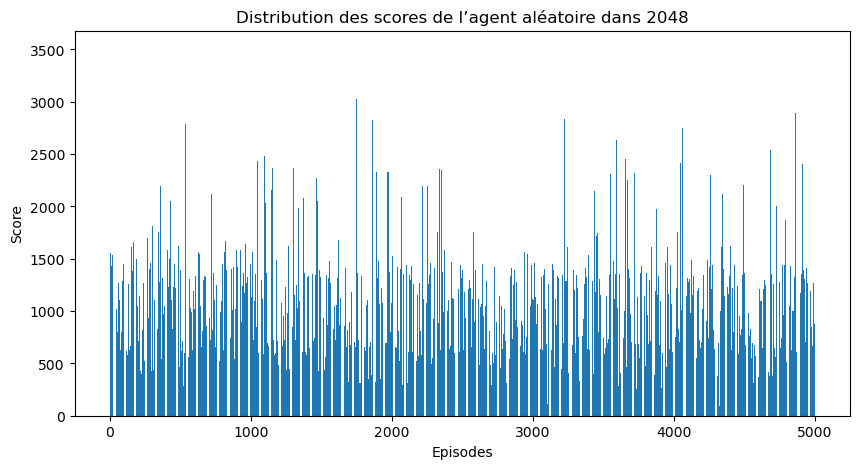

In [35]:
# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Distribution des scores de l’agent aléatoire dans 2048')
plt.show()


In [20]:
agent = DQNAgent(input_shape=(4, 4), num_actions=4)

# Après avoir créé le modèle, vous pouvez vérifier le nombre de couches
# num_layers = len(agent.model.layers)
# print(f"Nombre de couches dans le modèle : {num_layers}")

print(agent.model.summary())

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_36 (Flatten)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,614 (225.06 KB)

 Trainable params: 19,204 (75.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,410 (150.04 KB)

None


In [22]:
test_model = tf.keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=(4,)),
    layers.Dense(5, activation='relu'),
    layers.Dense(2, activation='softmax'),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
])

test_model.summary()  # Vérifiez combien de couches apparaissent ici


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_121 (Dense)               │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162 (648.00 B)

 Trainable params: 162 (648.00 B)

 Non-trainable params: 0 (0.00 B)